### <center>k-NN</center>
- k-NN (sales **prediction**)
- k-NN (music **recommendation**)

#### Sales Predection
----

100%|███████████████████████████████████████████| 36/36 [00:00<00:00, 92.93it/s]


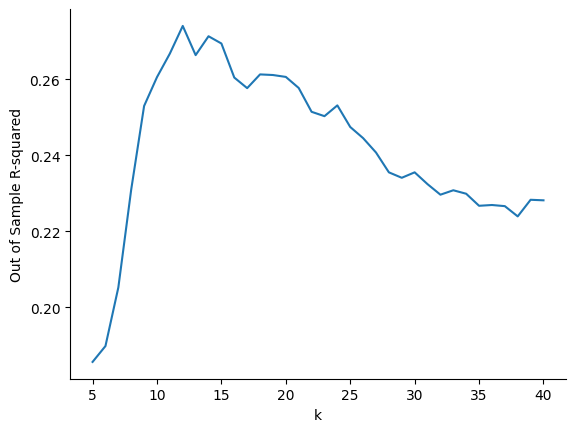

In [5]:
# Import packages
import pandas as pd
import sklearn.model_selection as sk_ms
import sklearn.metrics as sk_m
import sklearn.neighbors as sk_n
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

# load the data
df_customers = pd.read_csv('B2B sales.csv')
# split into training and testing set
df_train, df_test = sk_ms.train_test_split(df_customers, train_size = 0.7,
                                          random_state = 123, shuffle = True)

# k-NN (Sales Prediction)
# By going through the values of k from 5 to 40
score_list = []
for k in tqdm.tqdm(range(5, 41)):
    # Fit a k-NN model on the training set
    knn = sk_n.KNeighborsRegressor(n_neighbors=k)
    #nothing in the parenteces if without specific parameter
    knn.fit(df_train.loc[:, df_train.columns != 'ltv'], df_train.ltv)

    # Make predictions on the test set
    preds = knn.predict(df_test.loc[:, df_test.columns != 'ltv'])

    # Find the R-squared on the test set and append it to the
    # score list
    score_list.append(sk_m.r2_score(df_test.ltv, preds))

# Plot the results
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(range(5, 41), score_list)
plt.xlabel('k')
plt.ylabel('Out of Sample R-squared')
sns.despine()

#### music prediction
---

In [14]:
import math

In [6]:
# import packages
import string
import numpy as np

# import data
raw_data = pd.read_csv('canvas_survey.csv')
def find_col(filter_func, restrict_to_one = False):
    matching_cols = [i for i, j in enumerate(raw_data.columns) if filter_func(j)]
    if restrict_to_one:
        assert(len(matching_cols) == 1)
        return matching_cols[0]
    else:
        return matching_cols
name_col = find_col(lambda x : x == 'name', True)
section_col = find_col(lambda x : x == 'section', True)
gender_col = find_col(lambda x : 'gender' in x, True)
movie_cols = find_col(lambda x : 'movie' in x)
cuisine_cols = find_col(lambda x : 'cuisine' in x)

# Extract movie and cuisine names
def extract_name(s):
    s = s.split(":")[-1]
    s = [i for i in s if i in string.ascii_letters + " "]
    s = ''.join(s)
    return s.strip()

movies = [extract_name(raw_data.columns[i]) for i in movie_cols]
cuisines = [extract_name(raw_data.columns[i]) for i in cuisine_cols]

# Create the DataFrames
movies_df = {'name':raw_data.iloc[:, name_col],
             'section':raw_data.iloc[:, section_col].str.split('_').str[1],
             'gender':raw_data.iloc[:, gender_col]}
cuisines_df = {'name':raw_data.iloc[:, name_col],
               'section':raw_data.iloc[:, section_col].str.split('_').str[1],
               'gender':raw_data.iloc[:, gender_col]}
get_rating = lambda x : float('nan') if x.lower() in ["haven't seen it","no opinion","nan"] else int(x)
for name, col in zip(movies, movie_cols):
    movies_df[name] = raw_data.iloc[:, col].astype(str).apply(get_rating).tolist()
for name, col in zip(cuisines, cuisine_cols):
    cuisines_df[name] = raw_data.iloc[:, col].astype(str).apply(get_rating).tolist()
df_movies = pd.DataFrame(movies_df)
df_cuisines = pd.DataFrame(cuisines_df)


In [12]:
# summary statistics
df_movies.set_index('name')[movies].notnull().sum(axis=0).sort_values()
df_movies.set_index('name')[movies].mean(axis=0).sort_values()
df_movies.set_index('name')[movies].notnull().sum(axis=1).sort_values()
df_movies.set_index('name')[movies].mean(axis=1).sort_values()

name
Meng He              2.789474
Sophie Asgari        2.800000
Chengyi Gong         2.833333
Yi Gong              2.857143
Foivos Nichoritis    2.888889
                       ...   
Xinfang Zhang        5.000000
Kunal Kundu          5.000000
liyue Chen           5.000000
Sinan Zhao           5.000000
Sky Wu               5.000000
Length: 244, dtype: float64

In [15]:
# define distance
def dist(x, y):
    dists = [(i-j)**2 for i, j in zip(x,y)]
    n_movies = sum([pd.notnull(i) for i in dists])
    sum_dists = sum([i for i in dists if pd.notnull(i)])
    if n_movies == 0:
        return float('inf')
    else:
        return math.sqrt(sum_dists/n_movies)

In [16]:
# all distance calculation
def all_dists(df, ref):
    dists = []
    for user in df.index:
        if user != ref:
            dists.append((user, dist(df.loc[user,movies], df.loc[ref,movies])))
    return sorted(dists, key = lambda x : x[1])

In [17]:
# prediction
def make_preds(df, ref, k):
    
    preds = {}
    closest_rows = [i[0] for i in all_dists(df, ref)]
    df_sorted = df.loc[closest_rows, :]

    for movie in movies:
        relevant_scores = df_sorted.loc[df_sorted[movie].notnull(), movie]
        relevant_scores = relevant_scores.tolist()[:k]
        if len(relevant_scores) == 0:
            preds[movie] = float('nan')
        else:
            preds[movie] = sum(relevant_scores)/len(relevant_scores)
        
    return preds

In [18]:
# root-mean-squared-error calculation
def get_rmse(df, k):
    sum_sq_error = 0
    n_errors = 0
    
    for user in df.index:
        preds = make_preds(df, user, k)
        for movie in movies:
            squared_error = (df.loc[user, movie] - preds[movie])**2
            if pd.notnull(squared_error):
                sum_sq_error += squared_error
                n_errors += 1
    
    return math.sqrt(sum_sq_error/n_errors)

In [20]:
# return the row index of a name
def get_row_index(df, name):
    
    matching_rows = df_movies[df_movies.name.str.lower().str.contains(name.lower())]
    
    if len(matching_rows) == 0:
        print('No rows match this name')
    elif len(matching_rows) > 1:
        print(f'{len(matching_rows)} rows match this name: {matching_rows.name}')
    else:
        return matching_rows.index.tolist()[0]

100%|███████████████████████████████████████████| 10/10 [02:57<00:00, 17.79s/it]


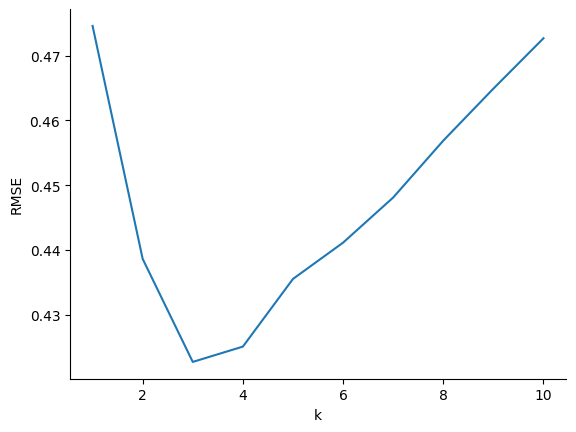

In [19]:
# Find the best k
mses = []
candidate_ks = range(1, 11)
import tqdm
for k in tqdm.tqdm(candidate_ks):
    mses.append(get_rmse(df_movies, k))
    
plt.plot(range(1,11), mses)
plt.xlabel('k')
plt.ylabel('RMSE')
sns.despine()

best_k = candidate_ks[mses.index(min(mses))]
# in reality, we need to split the data into training and testing set to decide the best k

In [25]:
# functionalized recommendation system

def movie_rec_system(person = 'Daniel Guetta', people_to_show=4):
    if person == '':
        return
    
    person_row = get_row_index(df_movies, person) # Find the row for this person
    dists = all_dists(df_movies, person_row)
    output_users = [person_row] + [i[0] for i in dists[:people_to_show]]
    df_preds = {i:make_preds(df_movies, i, best_k) for i in output_users}
    df_preds = pd.DataFrame(df_preds).transpose().round(2)

    # Remove all movies that the user has already seen
    for movie in df_preds:
        for user in df_preds.index:
            if pd.notnull(df_movies.loc[user, movie]):
                df_preds.loc[user, movie] = ''
    
    print('The following are the best movies to watch with the people closest to you:')
    for u in output_users[1:]:
        df = df_preds.loc[[person_row, u], :]
        df = df[df.columns[(df == '').sum() == 0]]
        df = df.mean().sort_values(ascending=False)
        print('  - Best movie to watch with ' + df_movies.loc[u, 'name'] + ' is ' + df.index[0])
            
    df_preds.insert(0, 'Name', df_movies.loc[output_users, 'name'])
    print('These recommendations were based on the following data')
    
    return df_preds

movie_rec_system("Ziyi Zhou")

The following are the best movies to watch with the people closest to you:
  - Best movie to watch with Mint Winyuprasitkul is Moneyball
  - Best movie to watch with Jiarui Luo is Moneyball
  - Best movie to watch with Letian Qi is Moneyball
  - Best movie to watch with Daisy Liu is Moneyball
These recommendations were based on the following data


,Name,The Godfather,Vicky Cristina Barcelona,Black Swan,Top Gun,Bourne Identity,Texas Chainsaw Massacre,Pretty Woman,Bridesmaids,Life is Beautiful,...,Inception,Working Girl,Pulp Fiction,Moneyball,Titanic,Avatar,Dark Knight,Iron Man,Crouching Tiger Hidden Dragon,National Lampoons Animal House
227,Ziyi Zhou,,2.33,,,4.00,3.0,4.0,3.33,,...,,3.33,,5.00,,,,4.67,,3.67
110,Mint Winyuprasitkul,4.33,3.33,4.0,3.67,4.33,2.67,4.0,4.00,4.33,...,,3.33,3.67,4.00,5.0,,,,4.33,3.67
208,Jiarui Luo,4.33,3.33,3.33,3.67,4.00,3.0,4.0,4.00,4.0,...,3.33,4.33,4.33,4.33,,,3.67,,4.0,3.00
57,Letian Qi,4.0,3.67,,4.0,4.00,,4.0,4.00,,...,,3.33,4.33,4.67,,,,,5.0,3.00
17,Daisy Liu,4.33,3.67,,,4.00,2.67,,3.33,,...,5.0,,4.0,4.00,4.67,3.67,,,3.67,4.00
